In [1]:
!pip install opacus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow import keras
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

pca = PCA(n_components=60)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

minmax = MinMaxScaler()
X_train_pca = minmax.fit_transform(X_train_pca)
X_test_pca = minmax.transform(X_test_pca)

if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)

class MNISTDatasetTrain(Dataset):
    def __init__(self):
        self.X_train_pca = X_train_pca
        self.y_train = y_train
        
    def __len__(self):
        return len(self.X_train_pca)

    def __getitem__(self, idx):
        return torch.Tensor(self.X_train_pca[idx]), torch.tensor([self.y_train[idx]])
    
class MNISTDatasetTest(Dataset):
    def __init__(self):
        self.X_test_pca = X_test_pca
        self.y_test = y_test
        
    def __len__(self):
        return len(self.X_test_pca)

    def __getitem__(self, idx):
        return torch.Tensor(self.X_test_pca[idx]), torch.tensor([self.y_test[idx]])
    




In [3]:
print(device)

cuda:0


ERRORS:  []
Using sigma=0.8023 and C=4


/usr/local/lib/python3.8/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Training Epoch: 1 [====================] (60157/60000)
Trained Epoch: 1 with loss= 1.912545, accuracy= 55.28, and epsilon= 1.51


/usr/local/lib/python3.8/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Test set metrics: 	Avg. loss: 1.3726, 	Accuracy: 7911/10000 (79.11%)

Training Epoch: 2 [====================] (59893/60000)
Trained Epoch: 2 with loss= 0.980454, accuracy= 81.05, and epsilon= 1.80
Test set metrics: 	Avg. loss: 0.6728, 	Accuracy: 8544/10000 (85.44%)

Training Epoch: 3 [====================] (60612/60000)
Trained Epoch: 3 with loss= 0.585684, accuracy= 86.38, and epsilon= 2.02
Test set metrics: 	Avg. loss: 0.4893, 	Accuracy: 8746/10000 (87.46%)

Training Epoch: 4 [====================] (59872/60000)
Trained Epoch: 4 with loss= 0.472335, accuracy= 86.49, and epsilon= 2.21
Test set metrics: 	Avg. loss: 0.4196, 	Accuracy: 8839/10000 (88.39%)

Training Epoch: 5 [====================] (60188/60000)
Trained Epoch: 5 with loss= 0.426240, accuracy= 87.88, and epsilon= 2.39
Test set metrics: 	Avg. loss: 0.3848, 	Accuracy: 8896/10000 (88.96%)

Training Epoch: 6 [====================] (60052/60000)
Trained Epoch: 6 with loss= 0.406196, accuracy= 88.14, and epsilon= 2.55
Test set m

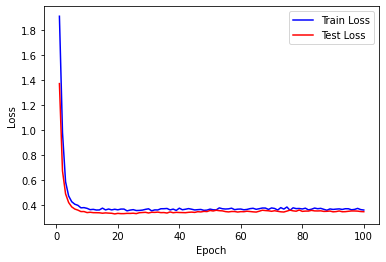

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from opacus import PrivacyEngine
from opacus.validators import ModuleValidator



epochs = 100
batch_size = 600
lr = 0.05
momentum = 0.9    #SET THIS PARAM
max_grad_norm = 4
sigma = 0.80230   #SET THIS PARAM
delta = 1e-5


train_loader = torch.utils.data.DataLoader(MNISTDatasetTrain(), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNISTDatasetTest(), batch_size=batch_size, shuffle=True)


class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.fc1 = nn.Linear(60, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    
model = Net()
model = model.to(device)
errors = ModuleValidator.validate(model, strict=False)
print("ERRORS: ", errors[-5:])
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=sigma,
    max_grad_norm=max_grad_norm
)

print(f"Using sigma={optimizer.noise_multiplier} and C={max_grad_norm}")

train_losses = []
test_losses = []
train_accs = []
test_accs = []

def train(epoch):
    model.train()
    epoch_loss = 0
    samples = 0
    batches = int(len(train_loader.dataset) / (batch_size*5))
    correct = 0
    count = 0
    print('Training Epoch: {} ['.format(epoch) + '-'*batches+']', end='\r')
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, torch.flatten(target))
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        samples += len(data)
        i = int(samples/(batch_size*5))
        count += 1
        print('Training Epoch: {} ['.format(epoch) +'='*(i)+ '-'*(batches-i)+'] ({}/{})'.format(samples, len(train_loader.dataset)), end='\r')
    print('Training Epoch: {} ['.format(epoch) + '='*batches+'] ({}/{})'.format(samples, len(train_loader.dataset)))
    epsilon = privacy_engine.get_epsilon(delta)
    print('Trained Epoch: {} with loss= {:.6f}, accuracy= {:.2f}, and epsilon= {:.2f}'.format(
            epoch,
            epoch_loss / count,
            100. * correct / len(train_loader.dataset),
            epsilon
    ))
    train_losses.append(epoch_loss / count)
    train_accs.append( (100. * correct / len(train_loader.dataset)).cpu().numpy() )
    # torch.save(model.state_dict(), './saved/model.pth')
    # torch.save(optimizer.state_dict(), './saved/optimizer.pth')
            
def test():
    model.eval()
    test_loss = 0
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, torch.flatten(target)).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            count+=1
    test_loss /= count
    test_losses.append(test_loss)
    test_accs.append( (100. * correct / len(test_loader.dataset)).cpu().numpy() )
    print('Test set metrics: \tAvg. loss: {:.4f}, \tAccuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))
    
    
for epoch in range(1, epochs + 1):
    train(epoch)
    test()
    
fig = plt.figure()
plt.plot(np.arange(1, 101, 1), train_losses, color='blue')
plt.plot(np.arange(1, 101, 1), test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
# save_file = "./saved/target_eps_{}_c_{}_epochs_{}_momentum_{}_{}"
    
# with open(save_file.format(
#         epsilon, max_grad_norm, epochs, momentum, 'train_losses.npy'
#     ), 'wb') as f:
#     np.save(f, np.array(train_losses))
    
# with open(save_file.format(
#         epsilon, max_grad_norm, epochs, momentum, 'train_accs.npy'
#     ), 'wb') as f:
#     np.save(f, np.array(train_accs))

# with open(save_file.format(
#         epsilon, max_grad_norm, epochs, momentum, 'test_losses.npy'
#     ), 'wb') as f:
#     np.save(f, np.array(test_losses))
    
# with open(save_file.format(
#         epsilon, max_grad_norm, epochs, momentum, 'test_accs.npy'
#     ), 'wb') as f:
#     np.save(f, np.array(test_accs))